Bandwidth: 0.2, Silhouette Score: 0.4663599259262865
Bandwidth: 0.24000000000000002, Silhouette Score: 0.5396049136546295
Bandwidth: 0.28, Silhouette Score: 0.5552815256961368
Bandwidth: 0.32000000000000006, Silhouette Score: 0.4916197510796066
Bandwidth: 0.36000000000000004, Silhouette Score: 0.4916197510796066
Bandwidth: 0.4, Silhouette Score: 0.4916197510796066
Bandwidth: 0.44000000000000006, Silhouette Score: 0.33885963160458743
Bandwidth: 0.48000000000000004, Silhouette Score: 0.33885963160458743
Best bandwidth: 0.28 with Silhouette Score: 0.5552815256961368


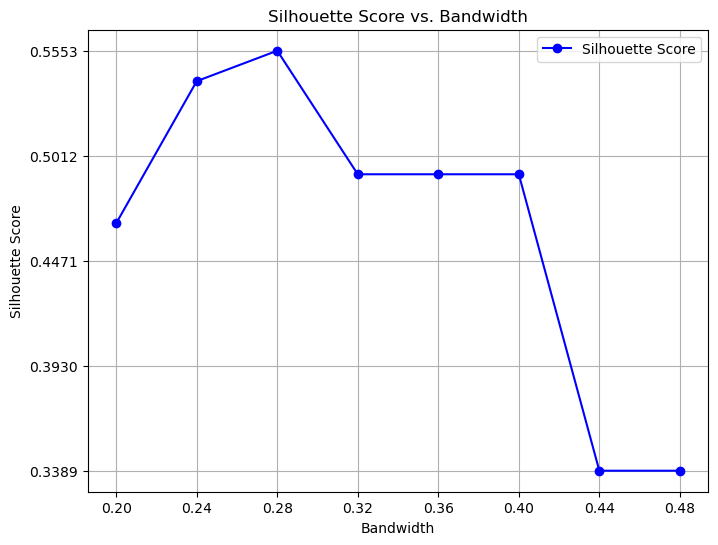

Cluster Centers: [[ 1.36288579e+01  1.90270698e+01  2.23944186e-02]
 [ 6.95315609e+00  1.21222659e+02  6.42401372e-01]
 [ 6.08612613e+00 -2.87977928e+01  6.74065315e-01]
 [ 2.15968750e+00  8.99331250e+01  2.16343750e-02]
 [ 1.83400000e+01  4.70881818e+01  6.86581818e-01]
 [ 2.30000000e-01 -1.60300000e+02  4.80000000e-02]
 [ 1.73200000e+01  1.66210000e+02  6.70500000e-01]]


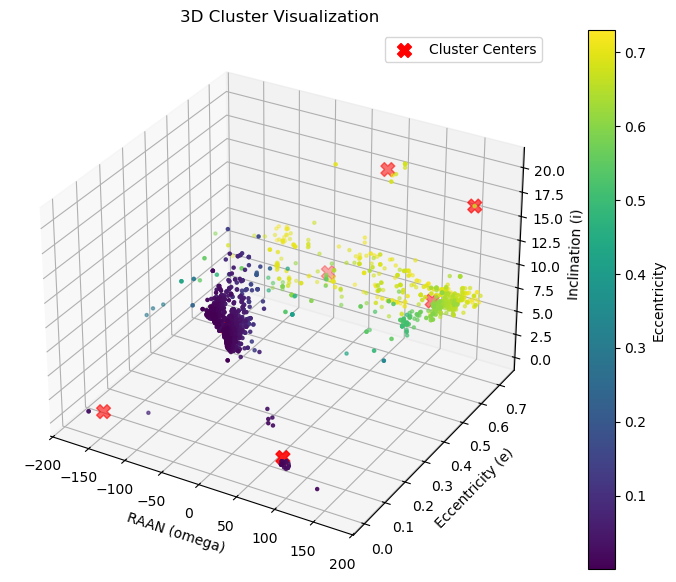

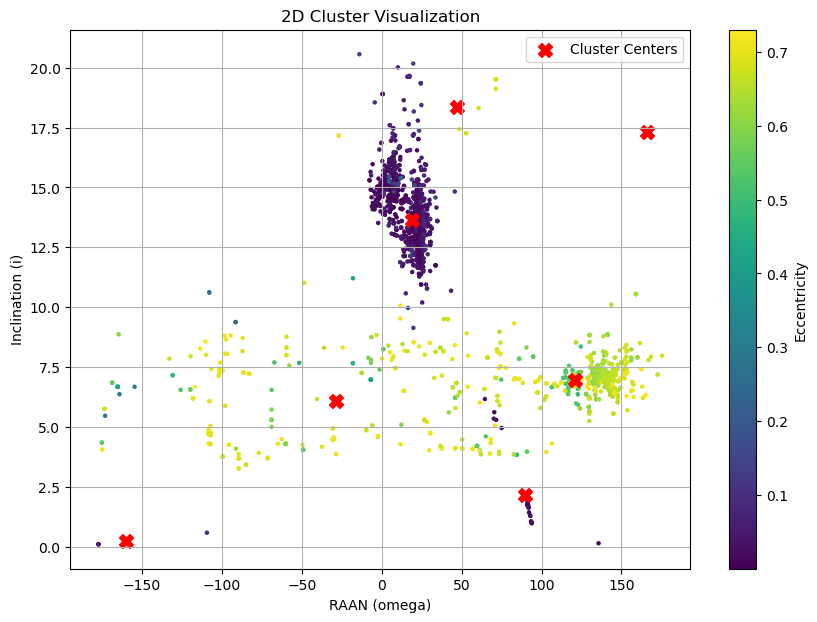

In [3]:
import cluster_finder
import numpy as np
from cluster_plotter import ClusterPlotter

testfile = r"input\stat_Master_02_geo_s1.crs"
data = cluster_finder.prepare_data_for_clustering(testfile)  # data is a named tuple (inc, raan, ecc)

bandwidths = np.arange(0.2, 0.5, 0.04)
best_bandwidth, scores = cluster_finder.find_best_bandwidth(data, bandwidths)
cluster_finder.plot_bandwidth_against_score(bandwidths, scores)

cluster_data = cluster_finder.find_clusters_mean_shift_clustering(data, best_bandwidth)
data = cluster_data.data 
labels = cluster_data.labels
cluster_centers = cluster_data.cluster_centers

print("Cluster Centers:", cluster_centers)

# Assuming ClusterPlotter is defined somewhere else
plotter = ClusterPlotter(data, labels, cluster_centers)
plotter.clusters_3d_plot("3D Cluster Visualization")
plotter.clusters_2d_plot("2D Cluster Visualization")

2002 geo
Bandwidth: 0.3, Silhouette Score: 0.5417155015594003
Best bandwidth: 0.3 with Silhouette Score: 0.5417155015594003
Bandwidth: 0.3, Silhouette Score: 0.5011749869927314
Best bandwidth: 0.3 with Silhouette Score: 0.5011749869927314
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.3520e+01 -2.2300e+00  3.5900e-02  0.0000e+00]
 [ 0.0000e+00  1.4090e+01  5.6600e+00  2.0900e-02  0.0000e+00]
 [ 0.0000e+00  1.4090e+01  5.6600e+00  2.0900e-02  0.0000e+00]
 ...
 [ 4.0000e+00  1.1000e-01 -1.7727e+02  3.5600e-02  4.0000e+00]
 [ 4.0000e+00  1.1000e-01 -1.7727e+02  3.5600e-02  4.0000e+00]
 [ 4.0000e+00  1.1000e-01 -1.7727e+02  3.5600e-02  4.0000e+00]]
Number of unmatched 10cm elements: 0
Number of rows where the first and last columns do not match: 803
Total number of rows: 2788
Mismatch percentage: 28.80%


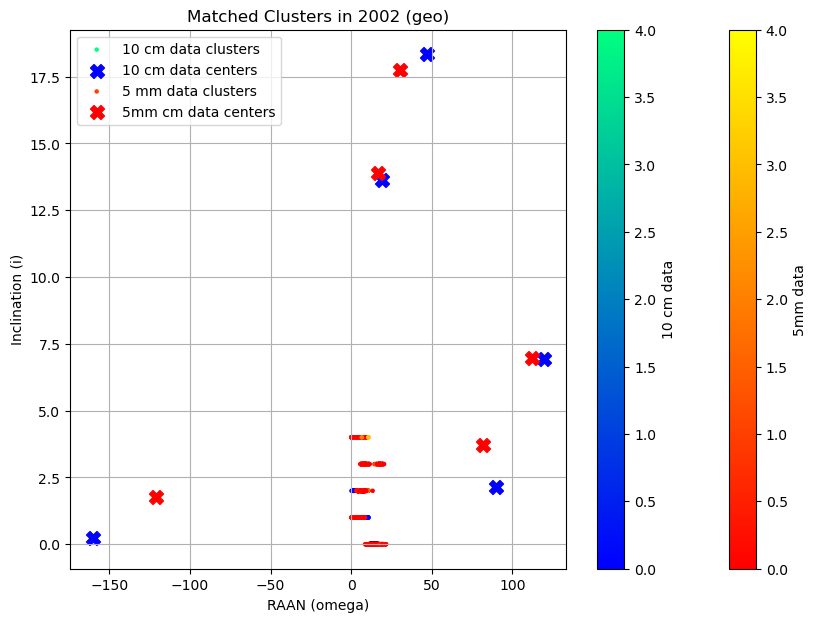

2003 geo
Bandwidth: 0.3, Silhouette Score: 0.5142741461973782
Best bandwidth: 0.3 with Silhouette Score: 0.5142741461973782
Bandwidth: 0.3, Silhouette Score: 0.4483718580813445
Best bandwidth: 0.3 with Silhouette Score: 0.4483718580813445
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.0630e+01 -3.3160e+01  4.9600e-02  0.0000e+00]
 [ 0.0000e+00  1.1460e+01 -2.4190e+01  5.9300e-02  0.0000e+00]
 [ 0.0000e+00  1.1460e+01 -2.4190e+01  5.9300e-02  0.0000e+00]
 ...
 [ 5.0000e+00  3.6600e+00 -1.2610e+02  9.3100e-02  4.0000e+00]
 [ 5.0000e+00  3.5700e+00 -1.2764e+02  5.2100e-02  4.0000e+00]
 [ 5.0000e+00  3.9400e+00 -1.1367e+02  6.9700e-02  4.0000e+00]]
Number of unmatched 10cm elements: 0
Number of rows where the first and last columns do not match: 782
Total number of rows: 2726
Mismatch percentage: 28.69%


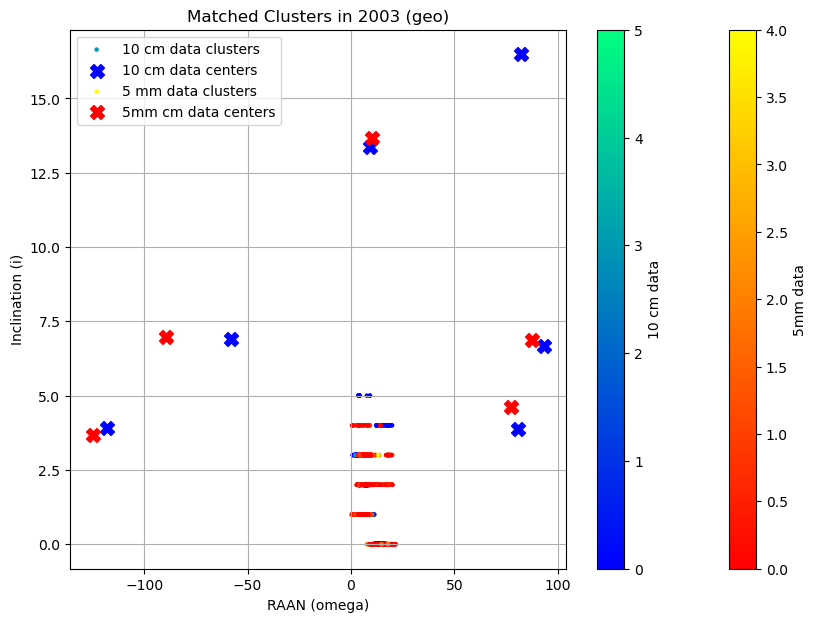

2004 geo
Bandwidth: 0.3, Silhouette Score: 0.3326492647892379
Best bandwidth: 0.3 with Silhouette Score: 0.3326492647892379
Bandwidth: 0.3, Silhouette Score: 0.39897551018510224
Best bandwidth: 0.3 with Silhouette Score: 0.39897551018510224
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.0890e+01 -3.3450e+01  7.6000e-02  0.0000e+00]
 [ 0.0000e+00  1.1010e+01 -2.9640e+01  5.9200e-02  0.0000e+00]
 [ 0.0000e+00  1.0470e+01 -3.5840e+01  6.6900e-02  0.0000e+00]
 ...
 [ 6.0000e+00  1.7600e+01 -1.5361e+02  6.6470e-01  2.0000e+00]
 [ 6.0000e+00  1.7680e+01 -1.4633e+02  6.9010e-01  2.0000e+00]
 [ 6.0000e+00  1.6570e+01 -1.6951e+02  6.6190e-01  2.0000e+00]]
Number of unmatched 10cm elements: 0
Number of rows where the first and last columns do not match: 440
Total number of rows: 2721
Mismatch percentage: 16.17%


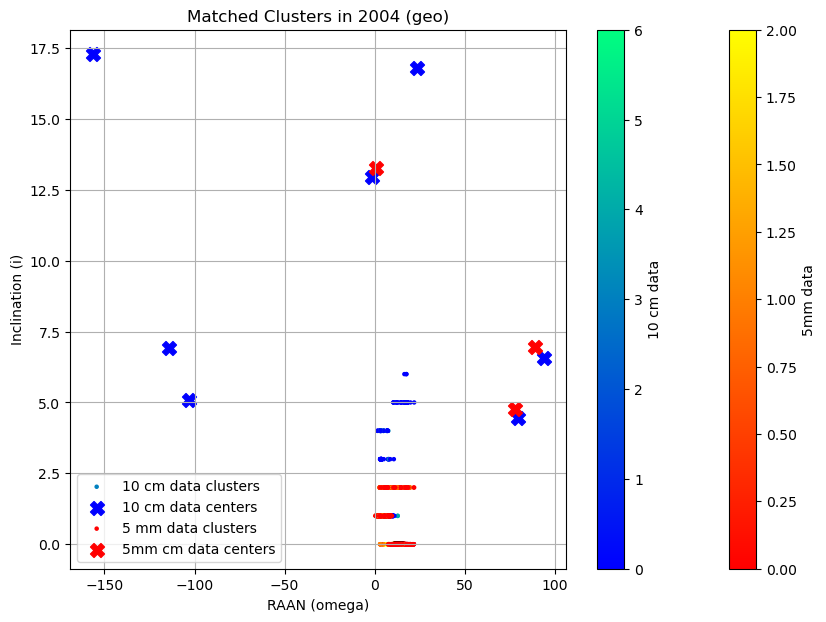

2005 geo
Bandwidth: 0.3, Silhouette Score: 0.48835217270391706
Best bandwidth: 0.3 with Silhouette Score: 0.48835217270391706
Bandwidth: 0.3, Silhouette Score: 0.473975282004004
Best bandwidth: 0.3 with Silhouette Score: 0.473975282004004
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.000e+00  1.037e+01 -3.943e+01  7.610e-02  0.000e+00]
 [ 0.000e+00  1.037e+01 -3.943e+01  7.610e-02  0.000e+00]
 [ 0.000e+00  9.900e+00 -4.805e+01  9.760e-02  0.000e+00]
 ...
 [ 6.000e+00  1.800e+01 -8.566e+01  3.257e-01  4.000e+00]
 [ 6.000e+00  2.091e+01  9.301e+01  6.016e-01  4.000e+00]
 [ 7.000e+00  1.996e+01  3.460e+00  6.753e-01  4.000e+00]]
Number of unmatched 10cm elements: 1223
Number of rows where the first and last columns do not match: 20
Total number of rows: 1461
Mismatch percentage: 1.37%


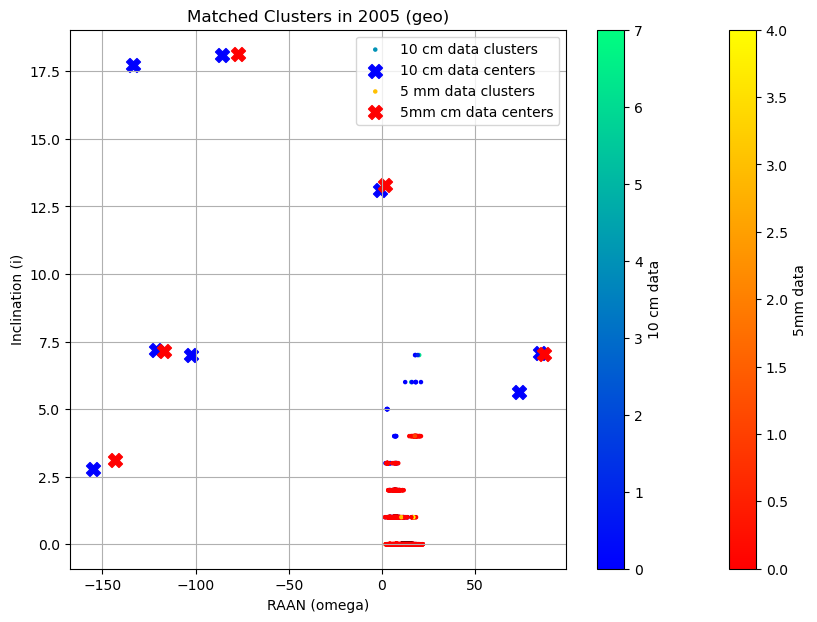

2002 gto
Bandwidth: 0.3, Silhouette Score: 0.350368387820107
Best bandwidth: 0.3 with Silhouette Score: 0.350368387820107
Bandwidth: 0.3, Silhouette Score: 0.0795794663835358
Best bandwidth: 0.3 with Silhouette Score: 0.0795794663835358
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.2000e+01 -1.3370e+01  1.8900e-02  1.0000e+00]
 [ 0.0000e+00  1.2000e+01 -1.3370e+01  1.8900e-02  1.0000e+00]
 [ 0.0000e+00  1.1930e+01 -1.3640e+01  1.2600e-02  1.0000e+00]
 ...
 [ 6.0000e+00  1.1000e-01 -1.7727e+02  3.5600e-02  4.0000e+00]
 [ 6.0000e+00  1.1000e-01 -1.7727e+02  3.5600e-02  4.0000e+00]
 [ 6.0000e+00  6.0800e+00 -1.4885e+02  3.4040e-01  6.0000e+00]]
Number of unmatched 10cm elements: 3
Number of rows where the first and last columns do not match: 1548
Total number of rows: 1573
Mismatch percentage: 98.41%


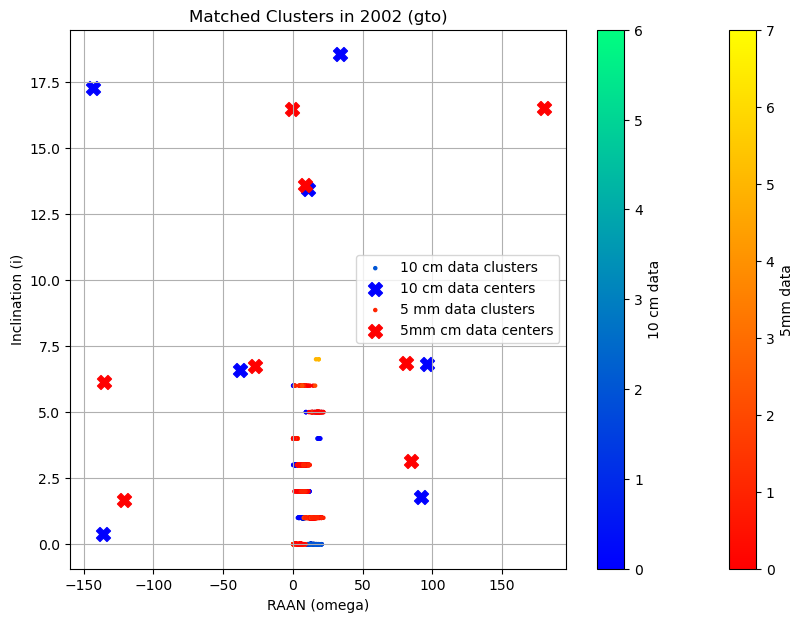

2003 gto
Bandwidth: 0.3, Silhouette Score: 0.23345316699831403
Best bandwidth: 0.3 with Silhouette Score: 0.23345316699831403
Bandwidth: 0.3, Silhouette Score: 0.24090267936131193
Best bandwidth: 0.3 with Silhouette Score: 0.24090267936131193
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.0690e+01 -3.3540e+01  6.4500e-02  0.0000e+00]
 [ 0.0000e+00  1.1220e+01 -2.3480e+01  3.0700e-02  0.0000e+00]
 [ 0.0000e+00  1.1720e+01 -1.7520e+01  2.3000e-02  0.0000e+00]
 ...
 [ 7.0000e+00  1.1460e+01 -1.0002e+02  1.9720e-01  6.0000e+00]
 [ 7.0000e+00  2.0710e+01  4.1100e+00  1.4060e-01  0.0000e+00]
 [ 7.0000e+00  1.2010e+01  8.2500e+00  3.1170e-01  0.0000e+00]]
Number of unmatched 10cm elements: 2
Number of rows where the first and last columns do not match: 1205
Total number of rows: 2516
Mismatch percentage: 47.89%


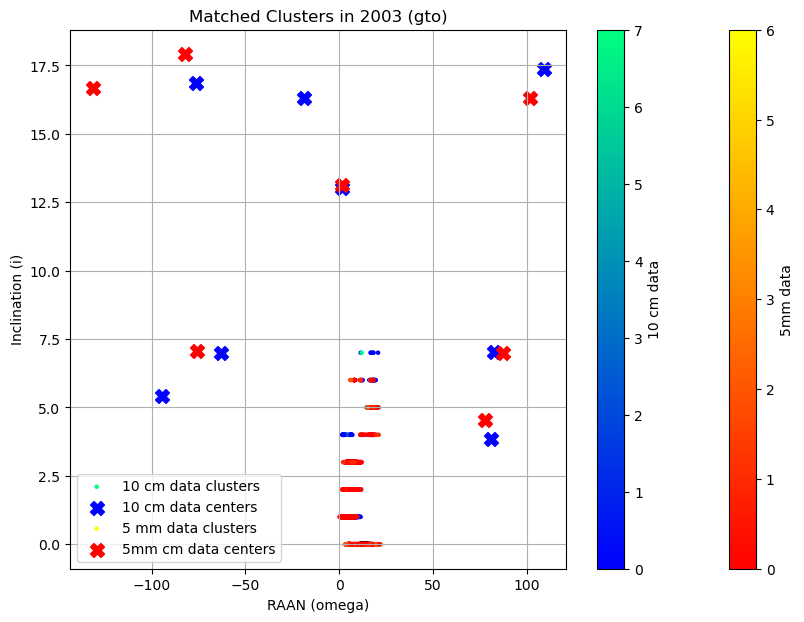

2004 gto
Bandwidth: 0.3, Silhouette Score: 0.21899598809042745
Best bandwidth: 0.3 with Silhouette Score: 0.21899598809042745
Bandwidth: 0.3, Silhouette Score: 0.235241113342343
Best bandwidth: 0.3 with Silhouette Score: 0.235241113342343
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.0890e+01 -3.3450e+01  7.6000e-02  0.0000e+00]
 [ 0.0000e+00  1.0140e+01 -3.9360e+01  6.4300e-02  0.0000e+00]
 [ 0.0000e+00  1.1010e+01 -2.9640e+01  5.9200e-02  0.0000e+00]
 ...
 [ 4.0000e+00  6.7400e+00 -1.1937e+02  7.1570e-01  3.0000e+00]
 [ 4.0000e+00  6.9500e+00 -1.3495e+02  7.2170e-01  3.0000e+00]
 [ 4.0000e+00  1.0610e+01 -4.4290e+01  4.3050e-01  3.0000e+00]]
Number of unmatched 10cm elements: 3
Number of rows where the first and last columns do not match: 490
Total number of rows: 1165
Mismatch percentage: 42.06%


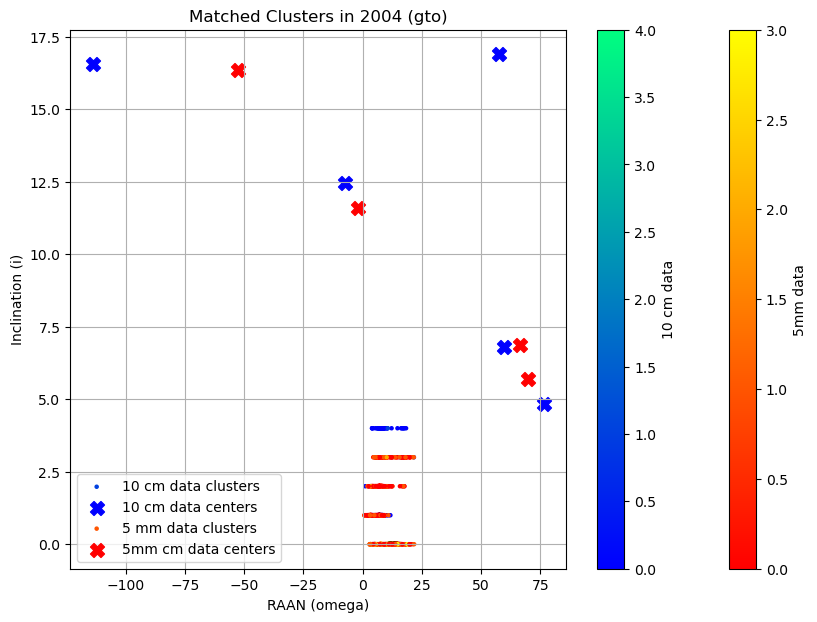

2005 gto
Bandwidth: 0.3, Silhouette Score: -0.08292459920629108
Best bandwidth: 0.3 with Silhouette Score: -0.08292459920629108
Bandwidth: 0.3, Silhouette Score: 0.39783267353254953
Best bandwidth: 0.3 with Silhouette Score: 0.39783267353254953
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.0850e+01 -2.5050e+01  1.3200e-02  0.0000e+00]
 [ 0.0000e+00  1.0880e+01 -2.3700e+01  5.3000e-03  0.0000e+00]
 [ 0.0000e+00  1.0970e+01 -2.3250e+01  7.2000e-03  0.0000e+00]
 ...
 [ 3.0000e+00  2.9400e+00 -1.2679e+02  3.7100e-02  0.0000e+00]
 [ 3.0000e+00  2.5100e+00 -1.5396e+02  6.6300e-02  0.0000e+00]
 [ 3.0000e+00  2.5100e+00 -1.5396e+02  6.6300e-02  0.0000e+00]]
Number of unmatched 10cm elements: 1134
Number of rows where the first and last columns do not match: 72
Total number of rows: 646
Mismatch percentage: 11.15%


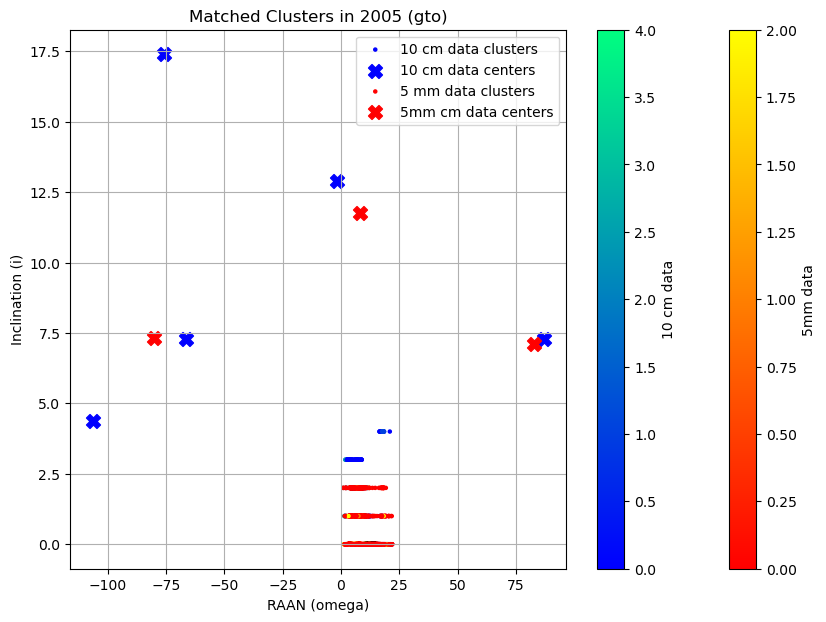

2002 fol
Bandwidth: 0.3, Silhouette Score: 0.17372771182373034
Best bandwidth: 0.3 with Silhouette Score: 0.17372771182373034
Bandwidth: 0.3, Silhouette Score: 0.2400731627162768
Best bandwidth: 0.3 with Silhouette Score: 0.2400731627162768
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.2140e+01 -1.0380e+01  2.9000e-03  0.0000e+00]
 [ 0.0000e+00  1.1730e+01 -2.2350e+01  8.9300e-02  0.0000e+00]
 [ 0.0000e+00  1.2230e+01 -9.5900e+00  1.9200e-02  0.0000e+00]
 ...
 [ 4.0000e+00  1.8780e+01  2.9320e+01  6.7410e-01  5.0000e+00]
 [ 4.0000e+00  1.8340e+01 -3.5300e+01  6.8240e-01  5.0000e+00]
 [ 5.0000e+00  1.7870e+01 -1.7397e+02  6.5710e-01  6.0000e+00]]
Number of unmatched 10cm elements: 0
Number of rows where the first and last columns do not match: 66
Total number of rows: 234
Mismatch percentage: 28.21%


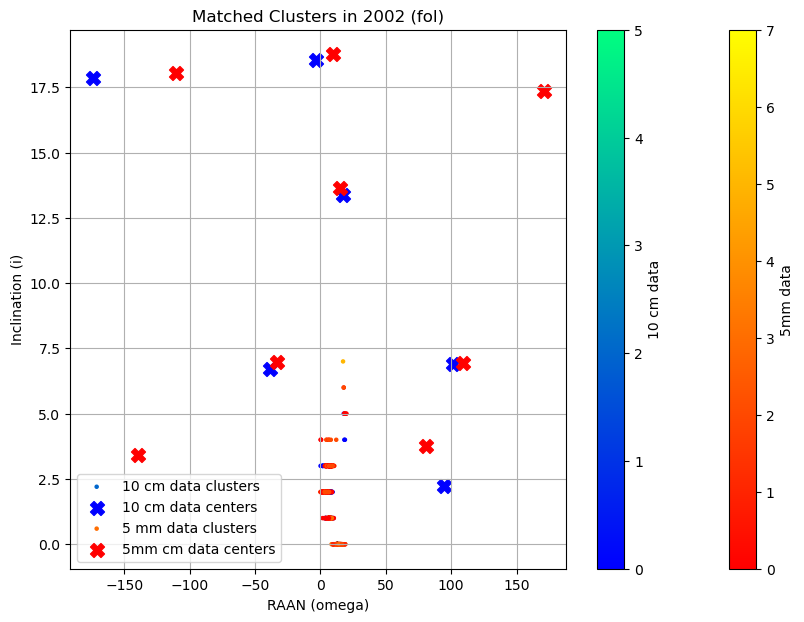

2003 fol
Bandwidth: 0.3, Silhouette Score: 0.34603286185469884
Best bandwidth: 0.3 with Silhouette Score: 0.34603286185469884
Bandwidth: 0.3, Silhouette Score: 0.27315191321637466
Best bandwidth: 0.3 with Silhouette Score: 0.27315191321637466
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.1010e+01 -3.4190e+01  9.7000e-02  0.0000e+00]
 [ 0.0000e+00  1.1370e+01 -2.7390e+01  7.6000e-02  0.0000e+00]
 [ 0.0000e+00  1.1370e+01 -2.7390e+01  7.6000e-02  0.0000e+00]
 ...
 [ 6.0000e+00  1.2980e+01 -1.0194e+02  6.3930e-01  4.0000e+00]
 [ 7.0000e+00  1.7880e+01 -9.9270e+01  2.7530e-01  5.0000e+00]
 [ 7.0000e+00  1.8000e+01 -1.5467e+02  3.5880e-01  5.0000e+00]]
Number of unmatched 10cm elements: 4
Number of rows where the first and last columns do not match: 285
Total number of rows: 1146
Mismatch percentage: 24.87%


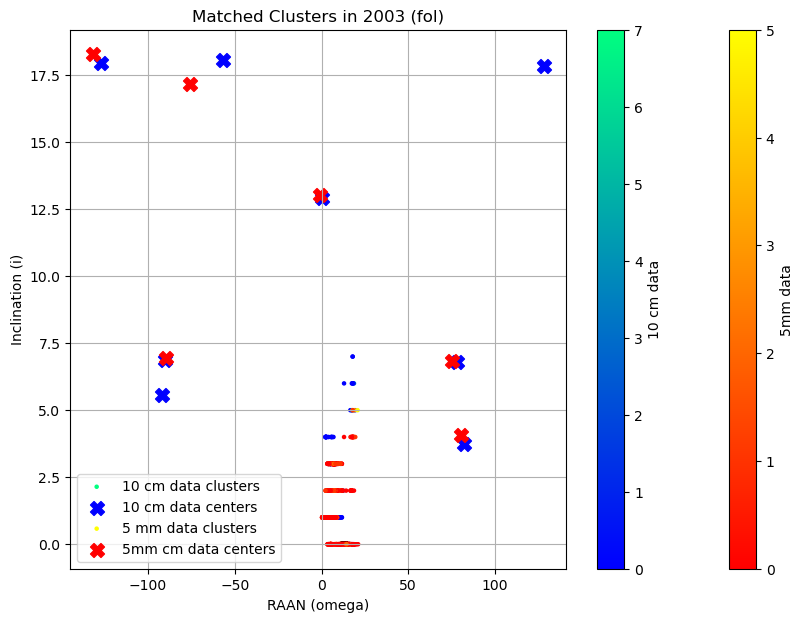

2004 fol


In [ ]:
import cluster_finder
import numpy as np
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from cluster_plotter import ClusterPlotter  # Assuming your plotting module is saved as cluster_plotter.py

seed = 1
years = ["2002", "2003", "2004", "2005"]
orbit_types = ["geo", "gto", "fol"]

cluster_evolution = {}
updated_10cm_cluster_evolution = {}

cluster_centers_5mm_dict = {}
cluster_centers_10cm_dict = {}
matches_dict = {}  # Store matched clusters

bandwidths = [0.3]
for orbit_type in orbit_types: 
    for year in years: 
        print(year, orbit_type)
        file_5mm, file_10cm = cluster_finder.get_files_for_cluster_evolution(year, orbit_type, seed, "input")
        clusters_5mm, clusters_10cm, clusters_5mm_array, clusters_10cm_array = cluster_finder.find_clusters_for_one_year(file_5mm, file_10cm, bandwidths)
                
        # Add clusters to the evolution dictionary
        cluster_evolution[(year, orbit_type, seed)] = {
            "clusters_5mm": clusters_5mm,
            "clusters_10cm": clusters_10cm
        }
        
        # Compare clusters and store updated data
        updated_10cm_cluster_data = cluster_finder.cluster_comparison(clusters_5mm_array, clusters_10cm_array)
        updated_10cm_cluster_evolution[(year, orbit_type, seed)] = updated_10cm_cluster_data

        # Get cluster centers
        clusters_center_5mm = clusters_5mm.cluster_centers
        clusters_center_10cm = clusters_10cm.cluster_centers

        # Match clusters using Hungarian algorithm
        matches, unmatched_10cm, unmatched_5mm = cluster_finder.match_clusters(clusters_center_10cm, clusters_center_5mm)
        matches_dict[(year, orbit_type, seed)] = matches

        # Store cluster centers for plotting
        cluster_centers_5mm_dict[(year, orbit_type, seed)] = clusters_center_5mm
        cluster_centers_10cm_dict[(year, orbit_type, seed)] = clusters_center_10cm

        # Visualize matched clusters
        plotter_5mm = ClusterPlotter(clusters_5mm_array, clusters_5mm.labels, clusters_center_5mm)
        plotter_5mm.combined_clusters_2d_plot(
            clusters_10cm_array, clusters_10cm.labels, clusters_center_10cm,
            title=f"Matched Clusters in {year} ({orbit_type})"
        )

cluster_finder.plot_cluster_center_evolution(cluster_centers_5mm_dict, cluster_centers_10cm_dict)
print("Matches: Row, col, distance")
print(matches)
print("Unmatched data")
print(unmatched_10cm, unmatched_5mm)

Bandwidth: 0.3, Silhouette Score: 0.5417155015594003
Best bandwidth: 0.3 with Silhouette Score: 0.5417155015594003
Bandwidth: 0.3, Silhouette Score: 0.5011749869927314
Best bandwidth: 0.3 with Silhouette Score: 0.5011749869927314
5mm dataset clusters: 5
10cm dataset clusters: 5
Total 10cm Cluster Elements: 2788
Total 5mm Cluster Elements: 11089
3
3
Updated 10cm Cluster Data with 5mm Cluster Labels:
[[ 0.0000e+00  1.3520e+01 -2.2300e+00  3.5900e-02  0.0000e+00]
 [ 0.0000e+00  1.4090e+01  5.6600e+00  2.0900e-02  0.0000e+00]
 [ 0.0000e+00  1.4090e+01  5.6600e+00  2.0900e-02  0.0000e+00]
 ...
 [ 4.0000e+00  1.1000e-01 -1.7727e+02  3.5600e-02  4.0000e+00]
 [ 4.0000e+00  1.1000e-01 -1.7727e+02  3.5600e-02  4.0000e+00]
 [ 4.0000e+00  1.1000e-01 -1.7727e+02  3.5600e-02  4.0000e+00]]
Number of unmatched 10cm elements: 0
Number of rows where the first and last columns do not match: 803
Total number of rows: 2788
Mismatch percentage: 28.80%


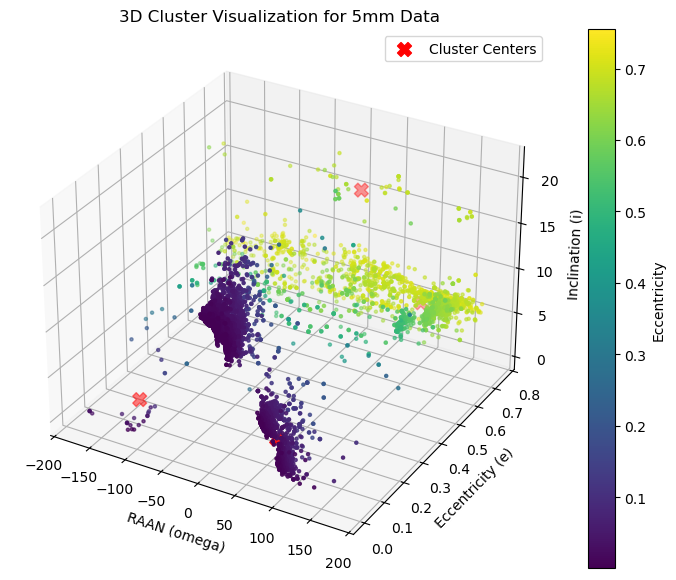

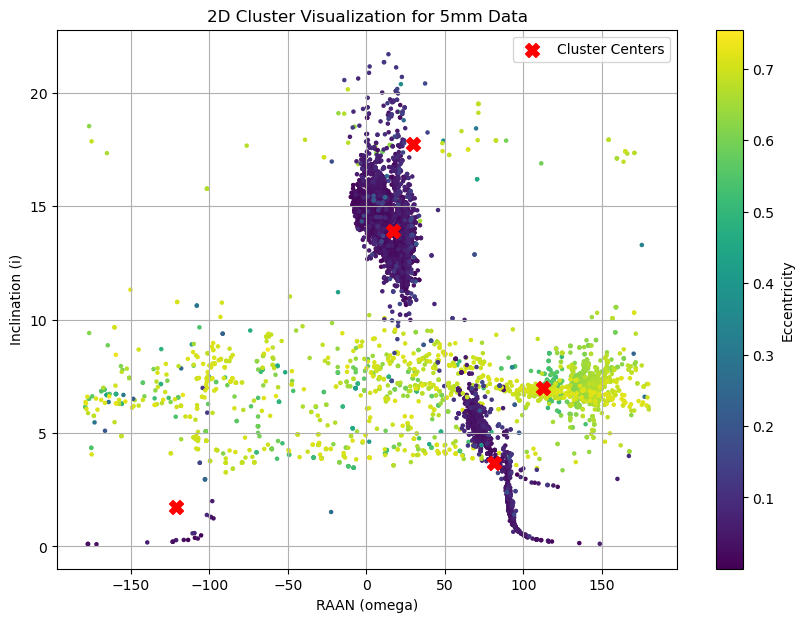

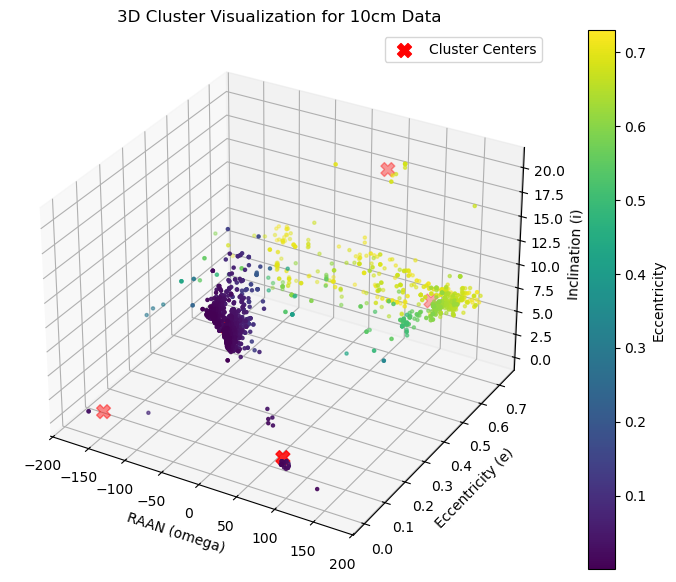

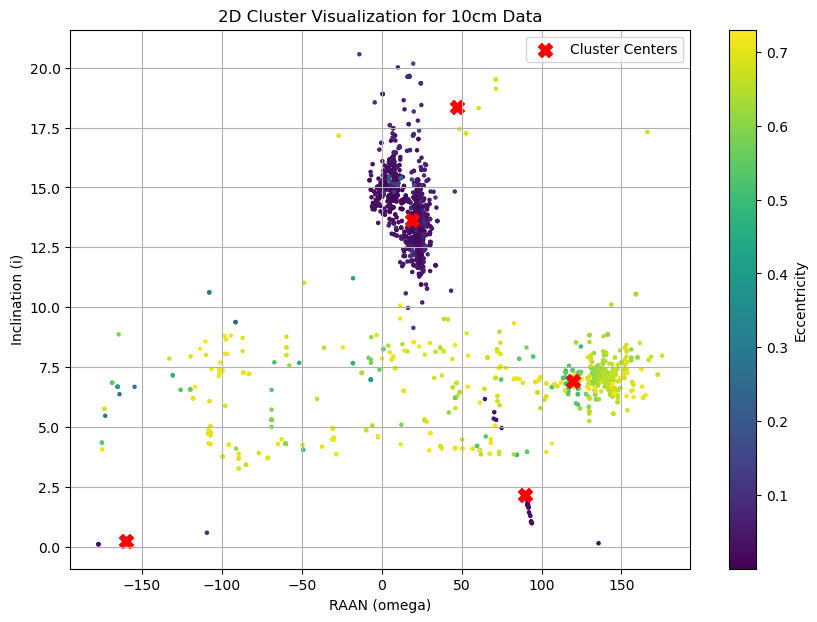

In [2]:
import cluster_finder
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from cluster_plotter import ClusterPlotter

data_5mm = r"input\small_Master_02_geo_s1.crs" #crossing data for objects larger than 5mm
data_5mm = cluster_finder.prepare_data_for_clustering(data_5mm)

bandwidths =  [0.3] #np.arange(0.2, 0.5, 0.05)#bandwidths to find
best_bandwidth_5mm, scores_5mm = cluster_finder.find_best_bandwidth(data_5mm, bandwidths)
clusters_5mm = cluster_finder.find_clusters_mean_shift_clustering(data_5mm, best_bandwidth_5mm)

cluster_data_5mm = clusters_5mm.data
labels_5mm = clusters_5mm.labels
cluster_centers_5mm = clusters_5mm.cluster_centers

data_10cm = r"input\stat_Master_02_geo_s1.crs" #crossing data for objects larger than 10cm
data_10cm = cluster_finder.prepare_data_for_clustering(data_10cm)

best_bandwidth_10cm, scores_10cm = cluster_finder.find_best_bandwidth(data_10cm, bandwidths)
clusters_10cm = cluster_finder.find_clusters_mean_shift_clustering(data_10cm, best_bandwidth_10cm)

cluster_data_10cm = clusters_10cm.data
labels_10cm = clusters_10cm.labels
cluster_centers_10cm = clusters_10cm.cluster_centers

#store clusters for both datasets in numpy array
clusters_5mm = cluster_finder.store_clusters(cluster_data_5mm, labels_5mm)
clusters_10cm = cluster_finder.store_clusters(cluster_data_10cm, labels_10cm)
#print the number of clusters for both datasets
print(f"5mm dataset clusters: {len(clusters_5mm)}")
print(f"10cm dataset clusters: {len(clusters_10cm)}")

#convert clusters to array
clusters_5mm_array = cluster_finder.convert_clusters_to_array(clusters_5mm)
clusters_10cm_array = cluster_finder.convert_clusters_to_array(clusters_10cm)

updated_10cm_cluster_data = []
total_10cm_elements = sum([len(elements) for elements in clusters_10cm.values()])
total_5mm_elements = sum([len(elements) for elements in clusters_5mm.values()])
print(f"Total 10cm Cluster Elements: {total_10cm_elements}")
print(f"Total 5mm Cluster Elements: {total_5mm_elements}")

count = 0 #count number of matches

data_10cm = clusters_10cm_array[:, 1:]  #only the inc, raan, ecc, cluster label is removed
data_5mm = clusters_5mm_array[:, 1:]

print(len(data_10cm[0]))
print(len(data_5mm[0]))
for row_index, row_10cm in enumerate(data_10cm):  # Iterate over rows in the 10cm dataset
    matched = False
    matches = np.all(np.isclose(data_5mm, row_10cm, atol=1e-20), axis=1) #tolerance to 10e-20 is the way to go
    
    if np.any(matches):
        matched_indices = np.where(matches)[0]
        for idx in matched_indices:
            matched_row = clusters_5mm_array[idx]
            updated_10cm_cluster_data.append(
                [clusters_10cm_array[row_index, 0]] + list(row_10cm) + [matched_row[0]]
            )
            matched = True
            break  # Stop searching once the first match is found

    if not matched:
        count += 1

updated_10cm_cluster_data = np.array(updated_10cm_cluster_data)

print("Updated 10cm Cluster Data with 5mm Cluster Labels:")
print(updated_10cm_cluster_data)
print(f"Number of unmatched 10cm elements: {count}")#should be zero

first_column = updated_10cm_cluster_data[:, 0]  # First column: 10cm cluster labels
last_column = updated_10cm_cluster_data[:, -1]  # Last column: 5mm cluster labels
mismatches = first_column != last_column
num_mismatches = np.sum(mismatches)
print(f"Number of rows where the first and last columns do not match: {num_mismatches}")
print(f"Total number of rows: {updated_10cm_cluster_data.shape[0]}")
print(f"Mismatch percentage: {num_mismatches / updated_10cm_cluster_data.shape[0] * 100:.2f}%")

"""# Plotting for the 5mm dataset
plotter_5mm = ClusterPlotter(cluster_data_5mm, labels_5mm, cluster_centers_5mm)
plotter_5mm.clusters_3d_plot("3D Cluster Visualization for 5mm Data")
plotter_5mm.clusters_2d_plot("2D Cluster Visualization for 5mm Data")

# Plotting for the 10cm dataset
plotter_10cm = ClusterPlotter(cluster_data_10cm, labels_10cm, cluster_centers_10cm)
plotter_10cm.clusters_3d_plot("3D Cluster Visualization for 10cm Data")
plotter_10cm.clusters_2d_plot("2D Cluster Visualization for 10cm Data")"""

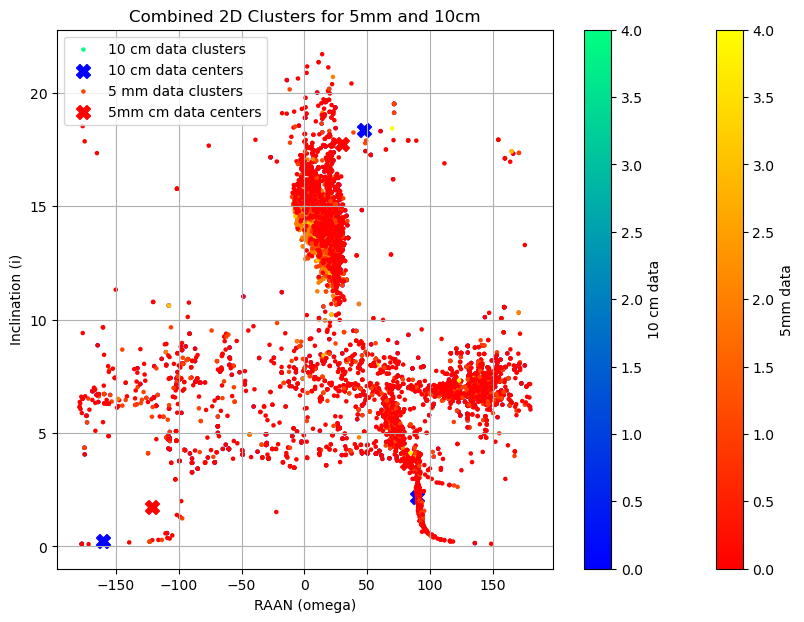

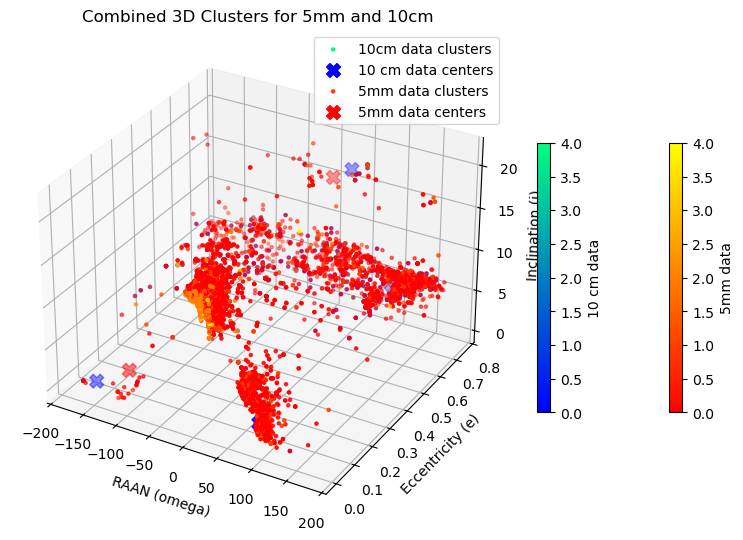

In [3]:
plotter_5mm = ClusterPlotter(data_5mm, labels_5mm, cluster_centers_5mm)

# Call combined 2D plot
plotter_5mm.combined_clusters_2d_plot(data_10cm, labels_10cm, cluster_centers_10cm,
                                      title="Combined 2D Clusters for 5mm and 10cm")

# Call combined 3D plot
plotter_5mm.combined_clusters_3d_plot(data_10cm, labels_10cm, cluster_centers_10cm,
                                      title="Combined 3D Clusters for 5mm and 10cm")


## Proof of Concept, it seems to work

In [ ]:
import numpy as np
from sklearn.cluster import MeanShift
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

#https://www.geeksforgeeks.org/ml-mean-shift-clustering/

#generate fake data with three main clusters
cluster_centers = [
    [5, 90, 0.2],    
    [15, 180, 0.7],  
    [20, 300, 0.4]   
]
cluster_std = [3, 0.7, 1]  # standard deviation for each feature

data, _ = make_blobs(n_samples=1000, centers=cluster_centers, cluster_std=cluster_std, random_state=42)

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

# Apply Mean Shift clustering
mean_shift = MeanShift(bandwidth=0.1) 
mean_shift.fit(normalized_data)
labels = mean_shift.labels_
cluster_centers = mean_shift.cluster_centers_
original_scale_centers = scaler.inverse_transform(cluster_centers)

print("Cluster labels:", labels)
print("Cluster centers (original scale):", original_scale_centers)

# 2D Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(data[:, 1], data[:, 0], c=data[:, 2], cmap='viridis', s=50, alpha=0.8)
plt.scatter(original_scale_centers[:, 1], original_scale_centers[:, 0], 
            c='red', marker='X', s=200, label='Cluster Centers')
plt.xlabel('RAAN (omega)')
plt.ylabel('Inclination (i)')
plt.title('2D Scatter Plot of Space Debris Clusters')
plt.colorbar(scatter, label='Eccentricity (e)')
plt.legend()
plt.show()

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data[:, 1], data[:, 0], data[:, 2], c=labels, cmap='viridis', s=50, alpha=0.8)
ax.scatter(original_scale_centers[:, 1], original_scale_centers[:, 0], original_scale_centers[:, 2], 
           c='red', marker='X', s=200, label='Cluster Centers')
ax.set_xlabel('RAAN (omega)')
ax.set_ylabel('Inclination (i)')
ax.set_zlabel('Eccentricity (e)')
ax.set_title('Fake Data')
fig.colorbar(scatter, ax=ax, label='Cluster Labels')
ax.legend()
plt.show()